In [52]:
import os
import pickle
import sys

sys.path.append(os.path.join(".."))

import gc
import glob
import os
import pickle

import joblib
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
from src.model_utils import CropLSTM, CropMLP, CropPL, reshape_data, custom_multiclass_report
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm


In [6]:

# defining paths
path_to_npys_data = os.path.join("..", "data", "npys_data")

pathFeatures = os.path.join(path_to_npys_data, "2040_2050")
pathResults = os.path.join("..", "results", "2040_2050")
pathMorf = os.path.join(path_to_npys_data, "features_morf_data.npy")

softmax = nn.Softmax(dim=1)

In [4]:
with open(os.path.join('..',
                    'data',
                    'processed_files',
                    'pkls',
                    'X_FR.pkl'), "rb") as fp:
    X = pickle.load(fp)

with open(os.path.join('..',
                    'data',
                    'processed_files',
                    'pkls',
                    'y_FR.pkl'), "rb") as fp:
    y = pickle.load(fp)

with open(os.path.join('..',
                    'data',
                    'processed_files',
                    'pkls',
                    'X_FR_holdout.pkl'), "rb") as fp:
    X_holdout = pickle.load(fp)

with open(os.path.join('..',
                    'data',
                    'processed_files',
                    'pkls',
                    'y_holdout.pkl'), "rb") as fp:
    y_holdout  = pickle.load(fp)

In [40]:
clf_dict = {
    # "MLP_final": os.path.join(
    #     '..', 'results', 'pickle_models', "Crop_MLP.ckpt"
    # ),
    "MLP_v0": os.path.join(
        '..', 'results', 'pickle_models', "Crop_MLP_v0.ckpt"
    ),
    # "MLP_v1": os.path.join(
    #     '..', 'results', 'pickle_models', "Crop_MLP_v1.ckpt"
    # ),
    # "MLP_v2": os.path.join(
    #     '..', 'results', 'pickle_models', "Crop_MLP_v2.ckpt"
    # )
}

In [44]:
def make_predictions(X, clf_dict):
    """Generates predictions using different models based on provided dataset

    Args:
        X (Array or DataFrame): features

    Returns:
        y_probs: dict
        keys - model name
        values - array of probabilities
    """
    y_probs = dict()
    
    # create an instance of pl.Trainer
    trainer = pl.Trainer(accelerator="gpu", devices=[0],)

    for model in tqdm(clf_dict):
        print(model)
        if "MLP" in model:
            model_filename = os.path.join("..", "results", "pickle_models", "mlp_FR.pkl")
            loaded_model = torch.load(model_filename)

            # Set the model to evaluation mode
            loaded_model.eval()

            # check metrics
            predictions = torch.cat(
                trainer.predict(
                    loaded_model,
                    DataLoader(
                        torch.tensor(X, dtype=torch.float), batch_size=2048
                    ),
                ),
                dim=0,
            )
            softmax = nn.Softmax(dim=1)
            y_prob = softmax(predictions.float()).numpy()
            y_probs[model] = y_prob

        elif model == "lstm":
            network = CropLSTM()
            checkpoint = torch.load(clf_dict[model])
            loaded_model = CropPL(net=network)
            loaded_model.load_state_dict(checkpoint["state_dict"])
            loaded_model.eval()

            # check metrics
            predictions = torch.cat(
                trainer.predict(
                    loaded_model,
                    DataLoader(
                        torch.tensor(reshape_data(X), dtype=torch.float),
                        batch_size=2048,
                    ),
                ),
                dim=0,
            )
            softmax = nn.Softmax(dim=1)
            y_prob = softmax(predictions.float()).numpy()
            y_probs[model] = y_prob

        else:
            # loading the models:
            loaded_model = pickle.load(open(clf_dict[model], "rb"))
            y_prob = loaded_model.predict_proba(X)
            y_probs[model] = y_prob

    return y_probs

In [45]:
# make predictions on test
test_preds = make_predictions(X['Test'], clf_dict)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
  0%|          | 0/1 [00:00<?, ?it/s]

MLP_v0


2023-09-22 07:59:38.470773: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-22 07:59:39.655024: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: 0it [00:00, ?it/s]

100%|██████████| 1/1 [00:09<00:00,  9.12s/it]


              precision    recall  f1-score   support

           0       0.98      0.86      0.91    878860
           1       0.36      0.70      0.48     11996
           2       0.48      0.67      0.56     63312
           3       0.50      0.76      0.60    137307

    accuracy                           0.83   1091475
   macro avg       0.58      0.75      0.64   1091475
weighted avg       0.88      0.83      0.85   1091475



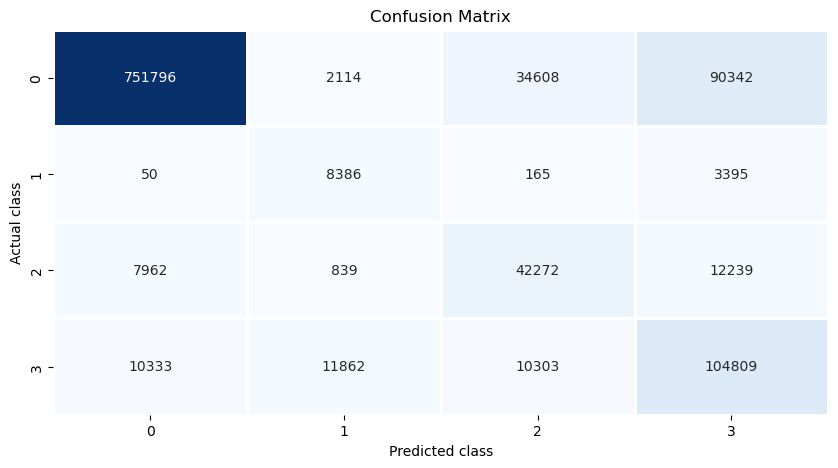

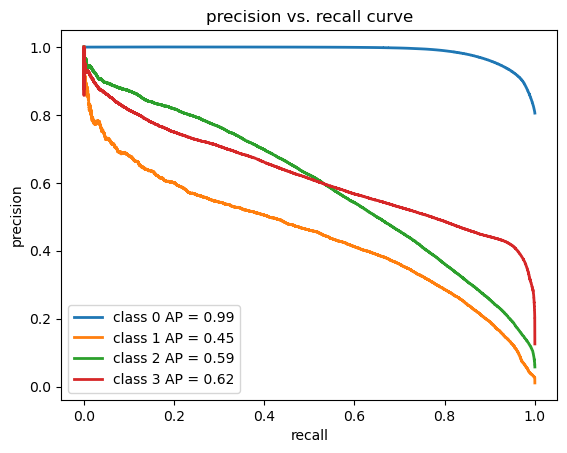

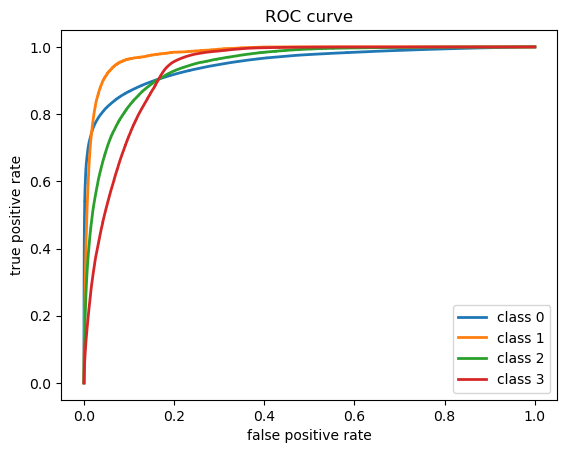

0 ROC AUC OvR: 0.9510
1 ROC AUC OvR: 0.9805
2 ROC AUC OvR: 0.9433
3 ROC AUC OvR: 0.9320
average ROC AUC OvR: 0.9517


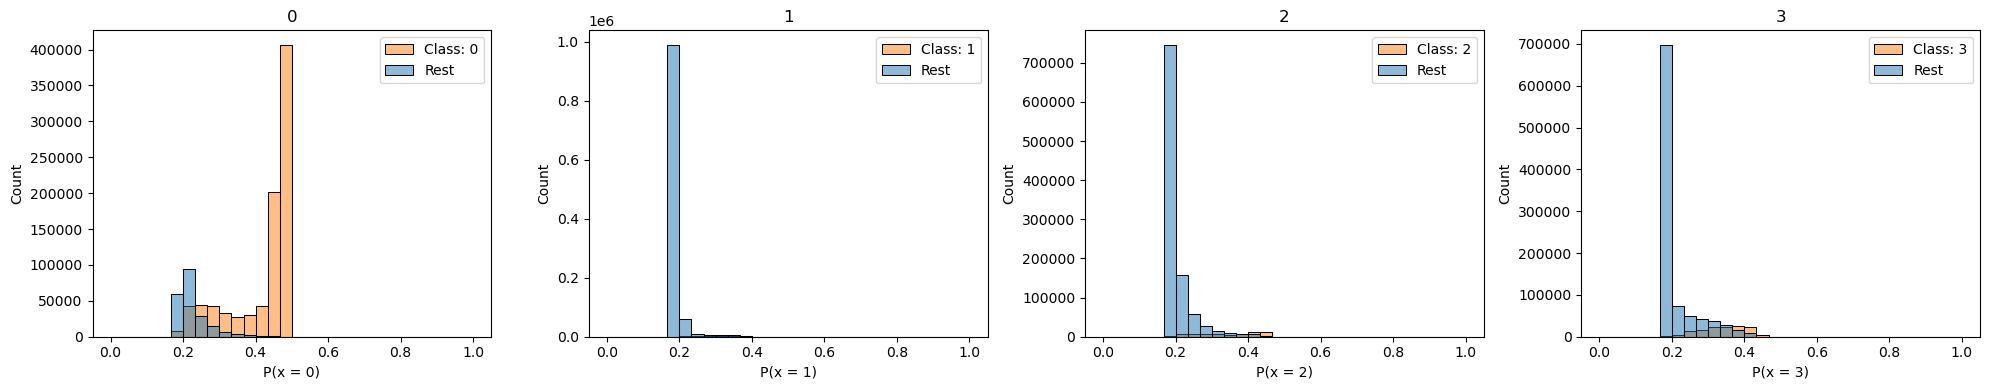

0 vs 1 ROC AUC OvO: 0.9877
1 vs 0 ROC AUC OvO: 0.9920
0 vs 2 ROC AUC OvO: 0.9447
2 vs 0 ROC AUC OvO: 0.9510
0 vs 3 ROC AUC OvO: 0.9508
3 vs 0 ROC AUC OvO: 0.9373
1 vs 2 ROC AUC OvO: 0.9740
2 vs 1 ROC AUC OvO: 0.9479
1 vs 3 ROC AUC OvO: 0.9097
3 vs 1 ROC AUC OvO: 0.7903
2 vs 3 ROC AUC OvO: 0.8937
3 vs 2 ROC AUC OvO: 0.8851
average ROC AUC OvO: 0.9304
None


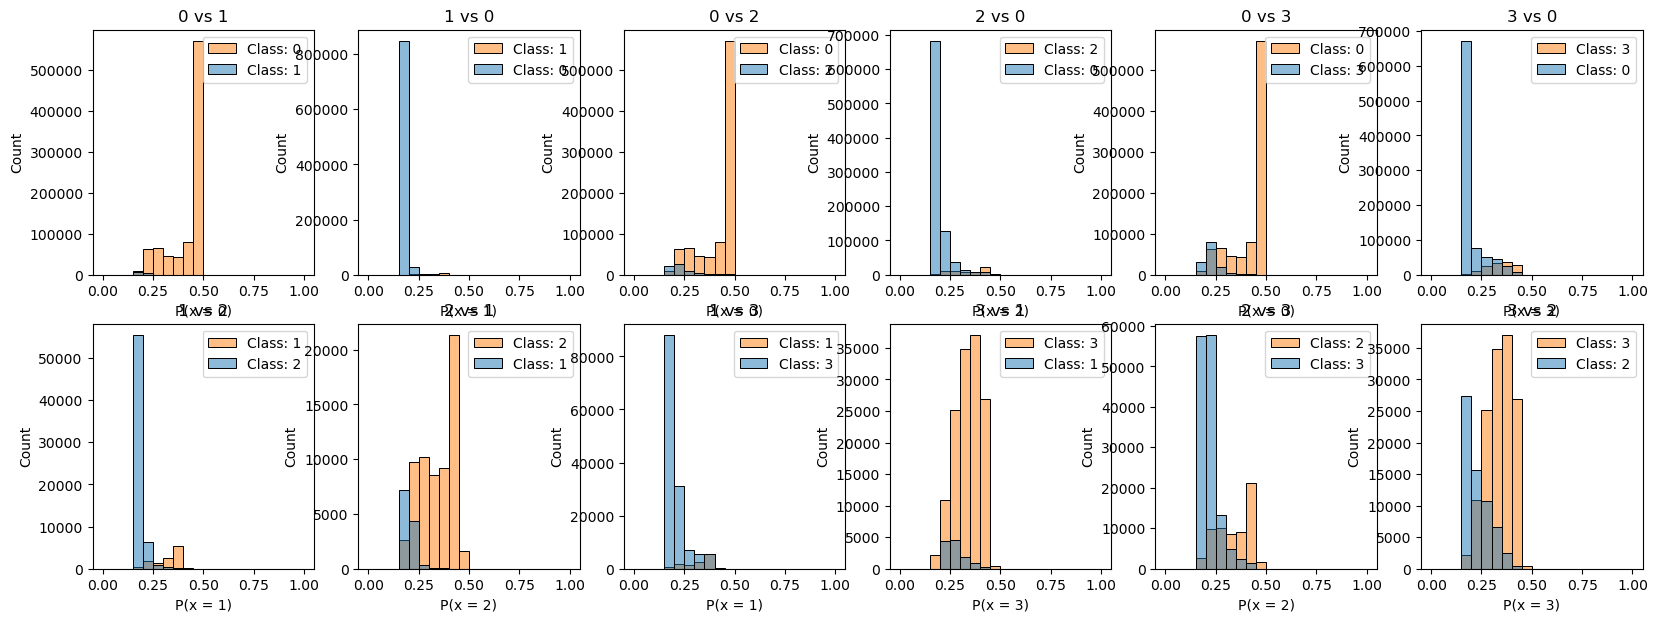

In [53]:
yprob = softmax(torch.tensor(test_preds['MLP_v0'], dtype=torch.float))
ypred = torch.argmax(yprob, 1)
ytest = torch.argmax(torch.tensor(y['Test'], dtype=torch.float), 1).cpu().numpy()


print(custom_multiclass_report(ytest, ypred, yprob))

In [54]:
# make predictions on test
holdout = make_predictions(X_holdout, clf_dict)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
  0%|          | 0/1 [00:00<?, ?it/s]

MLP_v0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: 0it [00:00, ?it/s]

100%|██████████| 1/1 [00:20<00:00, 20.16s/it]


In [61]:
np.unique(np.argmax(yprob, axis=1),return_counts=True)

(array([0, 2, 3]), array([3181551,   40986,   18876]))

              precision    recall  f1-score   support

         0.0       0.79      0.98      0.87   2565476
         1.0       0.00      0.00      0.00    147342
         2.0       0.03      0.01      0.01    196400
         3.0       0.00      0.00      0.00    332195

    accuracy                           0.78   3241413
   macro avg       0.21      0.25      0.22   3241413
weighted avg       0.63      0.78      0.69   3241413



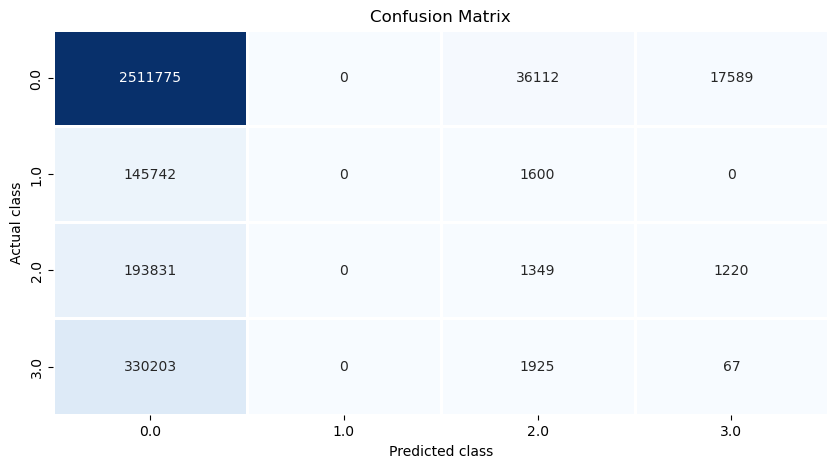

IndexError: index 4 is out of bounds for axis 1 with size 4

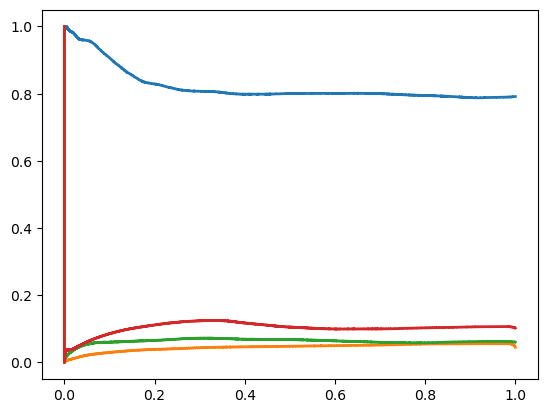

In [57]:
yprob = softmax(torch.tensor(holdout['MLP_v0'], dtype=torch.float))
ypred = torch.argmax(yprob, 1)
ytest = torch.tensor(y_holdout, dtype=torch.float)


print(custom_multiclass_report(ytest, ypred, yprob))